<a href="https://colab.research.google.com/github/ScientistLim/ProjectAW/blob/feature%2Fmodel%2Flstm-transformer/LSTM%26Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Transformer with LSTM

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
## print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [ ]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Conv1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Flatten, GlobalAveragePooling1D, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/종설프1_5팀/전처리 데이터/final_processed_feed_pressure.csv")

def get_outlier(df=None, column=None, weight=1.5):
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR * weight

    lowest = quantile_25 - IQR_weight *1.423/1.5
    highest = quantile_75 + IQR_weight *1.6/1.5

    outlier_idx = df[column][(df[column] < lowest) | (df[column] > highest)].index
    return outlier_idx

outlier_idx = get_outlier(df=data, column='Processed Feed Pressure', weight=1.5)
data.drop(outlier_idx, axis=0, inplace=True)

X_feed = data["Processed Feed Pressure"].values
y_feed = data["Processed Feed Pressure"].values

# 데이터 시퀀스 생성 함수
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# 시퀀스 길이
sequence_length = 10 #시퀀스 길이 50일경우 0.05~

# Feed pressure 데이터 시퀀스 생성
X_feed_seq, y_feed_seq = create_sequences(X_feed, sequence_length)

# 데이터 분할
X_feed_train, X_feed_test, y_feed_train, y_feed_test = train_test_split(X_feed_seq, y_feed_seq, test_size=0.2, random_state=42)

In [ ]:
print("Train shape : ",X_feed_train.shape)
print("Test shape : ",X_feed_test.shape)

Train shape :  (27987, 10)
Test shape :  (6997, 10)


In [ ]:
# 결측값을 _##_로 채우기 위해 pandas의 fillna 사용
train_X = train_df.fillna("_##_").values.flatten().astype(str)
val_X = val_df.fillna("_##_").values.flatten().astype(str)
test_X = pd.DataFrame(X_feed_test).fillna("_##_").values.flatten().astype(str)  # test_X도 처리

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

# target 값 처리
train_y = train_y.flatten()
val_y = val_y.flatten()


In [ ]:
# 데이터 크기 확인
print(f"train_X shape: {train_X.shape}, train_y shape: {train_y.shape}")
print(f"val_X shape: {val_X.shape}, val_y shape: {val_y.shape}")

# 인덱스 배열을 각각의 크기에 맞게 생성
trn_idx = np.random.permutation(len(train_y))  # train_X와 train_y의 길이를 맞춰 인덱스 생성
val_idx = np.random.permutation(len(val_y))    # 마찬가지로 val_X와 val_y의 길이 맞춤

# 데이터 섞기
train_X = train_X[trn_idx]
val_X = val_X[val_idx]
train_y = train_y[trn_idx]
val_y = val_y[val_idx]


train_X shape: (257480, 70), train_y shape: (25748,)
val_X shape: (22390, 70), val_y shape: (2239,)


In [ ]:
import random, os, sys
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Embedding, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, Bidirectional, LSTM
from keras.initializers import Ones, Zeros
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer  # Layer 클래스 임포트

# LayerNormalization 클래스 정의
class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)

    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:], initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:], initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)

    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

    def compute_output_shape(self, input_shape):
        return input_shape

# ScaledDotProductAttention 클래스 정의
class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)

    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x: K.batch_dot(x[0], x[1], axes=[2, 2]) / self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x: (-1e+10) * (1 - x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x: K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

# MultiHeadAttention 클래스 정의
class MultiHeadAttention():
    def __init__(self, n_head, d_model, d_k, d_v, dropout):
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        self.qs_layer = Dense(n_head * d_k, use_bias=False)
        self.ks_layer = Dense(n_head * d_k, use_bias=False)
        self.vs_layer = Dense(n_head * d_v, use_bias=False)
        self.attention = ScaledDotProductAttention(d_model)
        self.w_o = Dense(d_model)
        self.layer_norm = LayerNormalization()

    def __call__(self, q, k, v, mask=None):
        qs = self.qs_layer(q)  # [batch_size, len_q, n_head * d_k]
        ks = self.ks_layer(k)
        vs = self.vs_layer(v)

        def reshape(x):
            s = tf.shape(x)  # [batch_size, len_q, n_head * d_k]
            x = tf.reshape(x, [s[0], s[1], self.n_head, self.d_k])
            x = tf.transpose(x, [2, 0, 1, 3])
            return tf.reshape(x, [-1, s[1], self.d_k])  # [n_head * batch_size, len_q, d_k]

        qs = Lambda(reshape)(qs)
        ks = Lambda(reshape)(ks)
        vs = Lambda(reshape)(vs)

        if mask is not None:
            mask = Lambda(lambda x: K.repeat_elements(x, self.n_head, 0))(mask)

        head, attn = self.attention(qs, ks, vs, mask)

        def reshape_back(x):
            s = tf.shape(x)  # [n_head * batch_size, len_v, d_v]
            x = tf.reshape(x, [self.n_head, -1, s[1], self.d_v])
            x = tf.transpose(x, [1, 2, 0, 3])
            return tf.reshape(x, [-1, s[1], self.n_head * self.d_v])  # [batch_size, len_v, n_head * d_v]

        head = Lambda(reshape_back)(head)
        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        return self.layer_norm(outputs), attn

# Transformer 모델 정의
class Transformer():
    def __init__(self, maxlen, max_features, embed_size, n_head, d_k, d_v):
        self.maxlen = maxlen
        self.max_features = max_features
        self.embed_size = embed_size
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

    def build_model(self):
        # Input layer
        src_seq_input = Input(shape=(self.maxlen,))

        # Keras Embedding 레이어 (사전 훈련된 임베딩을 사용하지 않음)
        x = Embedding(input_dim=self.max_features, output_dim=self.embed_size)(src_seq_input)

        # LSTM 레이어 (CuDNNLSTM 대신 LSTM 사용)
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x)

        # Multi-Head Attention
        x, _ = MultiHeadAttention(n_head=self.n_head, d_model=self.embed_size, d_k=self.d_k, d_v=self.d_v, dropout=0.1)(x, x, x)

        # Global pooling
        avg_pool = GlobalAveragePooling1D()(x)
        max_pool = GlobalMaxPooling1D()(x)
        conc = concatenate([avg_pool, max_pool])

        # Fully connected layer
        conc = Dense(64, activation="relu")(conc)
        output = Dense(1, activation="sigmoid")(conc)

        # 모델 생성
        self.model = Model(inputs=src_seq_input, outputs=output)
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return self.model


In [ ]:
!pip install tensorflow pydot
!pip install pydot graphviz

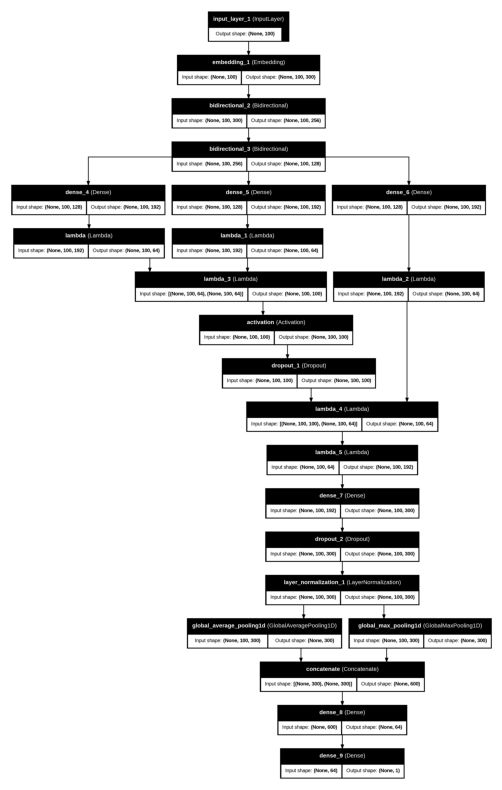

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Lambda  # Lambda 함수 임포트
import matplotlib.pyplot as plt

# Transformer 모델 생성 및 정의 (위 코드 동일)
transformer = Transformer(maxlen=100, max_features=20000, embed_size=300, n_head=3, d_k=64, d_v=64)
model = transformer.build_model()

# 모델 구조 시각화
plot_model(model, to_file='transformer_model.png', show_shapes=True, show_layer_names=True)

# 이미지 표시
img = plt.imread('transformer_model.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()


In [ ]:
import random, os, sys
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Embedding, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, Bidirectional, LSTM
from keras.layers import LayerNormalization, MultiHeadAttention
from tensorflow.keras.layers import Lambda
import tensorflow as tf

# 병렬 구조의 LSTM + Transformer 모델 정의
class ParallelLSTMTransformer():
    def __init__(self, maxlen, max_features, embed_size, n_head, d_k, d_v):
        self.maxlen = maxlen
        self.max_features = max_features
        self.embed_size = embed_size
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

    def build_model(self):
        # Input layer
        src_seq_input = Input(shape=(self.maxlen,))

        # Keras Embedding 레이어 (사전 훈련된 임베딩을 사용하지 않음)
        x = Embedding(input_dim=self.max_features, output_dim=self.embed_size)(src_seq_input)

        # 1. LSTM 경로
        lstm_out = Bidirectional(LSTM(128, return_sequences=True))(x)
        lstm_out = Bidirectional(LSTM(64, return_sequences=True))(lstm_out)

        # 2. Transformer 경로 (Multi-Head Attention)
        attn_out = MultiHeadAttention(num_heads=self.n_head, key_dim=self.d_k, value_dim=self.d_v, dropout=0.1)(x, x)
        attn_out = LayerNormalization()(attn_out)

        # 두 경로에서 나온 결과를 결합 (Concatenate)
        combined = concatenate([lstm_out, attn_out])

        # Global pooling
        avg_pool = GlobalAveragePooling1D()(combined)
        max_pool = GlobalMaxPooling1D()(combined)
        conc = concatenate([avg_pool, max_pool])

        # Fully connected layer
        conc = Dense(64, activation="relu")(conc)
        output = Dense(1, activation="sigmoid")(conc)

        # 모델 생성
        self.model = Model(inputs=src_seq_input, outputs=output)
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return self.model

# 모델 생성
parallel_model = ParallelLSTMTransformer(maxlen=100, max_features=20000, embed_size=300, n_head=3, d_k=64, d_v=64)
model = parallel_model.build_model()

# 모델 구조 요약 출력
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 100, 300)       │      6,000,000 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 100, 256)       │        439,296 │ embedding_2[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 100, 300)       │        231,276 │ embedding_2[0][0],     │
│ (MultiHeadAttention)      │                        │                │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 100, 128)       │        164,352 │ bidirectional_4[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 100, 300)       │            600 │ multi_head_attention[… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 100, 428)       │              0 │ bidirectional_5[0][0], │
│ (Concatenate)             │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 428)            │              0 │ concatenate_1[0][0]    │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_1    │ (None, 428)            │              0 │ concatenate_1[0][0]    │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 856)            │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 64)             │         54,848 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 1)              │             65 │ dense_10[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,890,437 (26.28 MB)

 Trainable params: 6,890,437 (26.28 MB)

 Non-trainable params: 0 (0.00 B)

## 모델 학습

In [ ]:
## Train the model
model.fit(train_X, train_y, batch_size=512, epochs=3, validation_data=(val_X, val_y))

In [ ]:
pred_val_y = model.predict([val_X], batch_size=1024, verbose=1)

thresholds = []
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    res = metrics.f1_score(val_y, (pred_val_y > thresh).astype(int))
    thresholds.append([thresh, res])
    print("F1 score at threshold {0} is {1}".format(thresh, res))

thresholds.sort(key=lambda x: x[1], reverse=True)
best_thresh = thresholds[0][0]
print("Best threshold: ", best_thresh)

In [ ]:
pred_test_y = model.predict([test_X], batch_size=1024, verbose=1)

pred_test_y = (pred_test_y > best_thresh).astype(int)
out_df = pd.DataFrame({"qid":test_df["qid"].values})
out_df['prediction'] = pred_test_y
out_df.to_csv("submission.csv", index=False)